In [2]:
from collections import defaultdict

import seisbench.data as sbd
import seisbench.generate as sbg
import numpy as np
import matplotlib.pyplot as plt
from seisbench.util import worker_seeding
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
import einops
import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import defaultdict
from sklearn.decomposition import PCA
from seisLM.utils import project_path

from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2, MultiDimWav2Vec2ForPreTraining
from seisLM.evaluation.analysis import compute_separation_fuzziness

/scicore/home/dokman0000/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model

Dataloader

1. only extract 1000 samples for each class (earthquake vs noise)
2. return meta data for each sample

In [4]:
project_path.gitdir()


'/scicore/home/dokman0000/liu0003/projects/seisLM'

In [5]:
class MetaDataKeepingSteeredGenerator(sbg.SteeredGenerator):
  def _clean_state_dict(self, state_dict):
    # Remove control information
    trace_type = state_dict["_control_"]["trace_type"]

    X, meta = state_dict["X"]
    path_ep_distance_km = meta.get("path_ep_distance_km", np.inf)
    path_hyp_distance_km = meta.get("path_hyp_distance_km", np.inf)

    state_dict = {
      "X": X,
      'trace_type': trace_type,
      "path_ep_distance_km": path_ep_distance_km,
      "path_hyp_distance_km": path_hyp_distance_km,
    }
    return state_dict

def get_loader():
  dataset_name = 'InstanceCountsCombined'
  task = '1'
  num_samples_per_trace_type = 2000

  dataset = sbd.__getattribute__(dataset_name)(
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    missing_component="copy",
    cache=None
  )
  metadata_df = dataset.metadata

  eval_set = 'dev'
  split = dataset.get_split(eval_set)

  task_csv = project_path.gitdir() + f'/data/targets/{dataset_name}/task{task}.csv'
  task_targets = pd.read_csv(task_csv)
  task_targets = task_targets[task_targets["trace_split"] == eval_set]


  eq_targets = task_targets[task_targets['trace_type'] == 'earthquake'].head(num_samples_per_trace_type)
  noise_targets = task_targets[task_targets['trace_type'] == 'noise'].head(num_samples_per_trace_type)

  task_targets = pd.concat([eq_targets, noise_targets])

  generator = MetaDataKeepingSteeredGenerator(split, task_targets)
  generator.add_augmentations(
    [
      sbg.SteeredWindow(windowlen=3001, strategy="pad"),
      sbg.ChangeDtype(np.float32),
      sbg.Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="std"),
    ]
  )
  batch_size  = 10
  num_workers = 2
  loader = DataLoader(
    generator, batch_size=batch_size, shuffle=False, num_workers=num_workers,
  )
  return loader


loader = get_loader()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_collections = {}

for model_type in ['pretrained', 'random_init']:

  model = LitMultiDimWav2Vec2.load_from_checkpoint(
    # '/home/liu0003/Desktop/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_layernorm_std_small_batch_6_datasets_42__2024-08-14-09h-06m-17s/checkpoints/epoch=33-step=893792.ckpt',
    '/scicore/home/dokman0000/liu0003/projects/seisLM/results/models/pretrained_seisLM/pretrain_config_std_norm_single_ax_8_datasets_32bit_scaleup_42__2024-08-29-20h-20m-36s/checkpoints/last.ckpt'
  ).model

  if model_type == 'random_init':
    model = MultiDimWav2Vec2ForPreTraining(model.config)

  model = model.to(device)
  model = model.eval()
  model_collections[model_type] = model
  del model

In [4]:
features_of_models = {}

for model_type, model in model_collections.items():
  batch_input_dict = defaultdict(list)
  batch_features_dict = defaultdict(list)

  for batch in tqdm.tqdm(loader):
    for key, value in batch.items():
      batch_input_dict[key].append(value)

    with torch.no_grad():
      input_values = batch['X']
      wav2vec2_output = model.wav2vec2(
        input_values=input_values.cuda(),
        output_hidden_states=True,
      )

    batch_features_dict['conv_features'].append(
      wav2vec2_output.extract_features.mean(axis=1)
    )

    for hidden_states_layer_idx, hidden_states in enumerate(wav2vec2_output.hidden_states):
      batch_features_dict[f'hidden_states_{hidden_states_layer_idx}'].append(
        hidden_states.mean(axis=1)
      )

  all_features_dict = defaultdict(list)
  all_input_values = defaultdict(list)

  for key, value in batch_features_dict.items():
    concat_features = torch.concatenate(value, axis=0).cpu().numpy()
    all_features_dict[key] = concat_features

  for key, value in batch_input_dict.items():
    if isinstance(value[0], torch.Tensor):
      concat_values = torch.cat(value, axis=0).cpu().numpy()
    elif isinstance(value[0], np.ndarray) or isinstance(value[0], list):
      concat_values = np.concatenate(value, axis=0)
    else:
      raise ValueError
    all_input_values[key] = concat_values


  features_of_models[model_type] = all_features_dict

  0%|          | 0/400 [00:00<?, ?it/s]2024-08-30 12:06:52,443 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-08-30 12:06:52,486 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
  0%|          | 0/400 [00:00<?, ?it/s]2024-08-30 12:07:07,371 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
2024-08-30 12:07:07,406 | seisbench | WARNING | Traces can not uniformly be identified using name. "get_idx_from_trace_name" will return only one possible matching trace.
100%|██████████| 400/400 [00:14<00:00, 26.79it/s]


In [5]:
from seisLM.utils import project_path


In [6]:
all_trace_types = all_input_values['trace_type']

fuzziness_dict = defaultdict(list)
for model_type, _ in model_collections.items():
  for key, feature in features_of_models[model_type].items():

    fuzziness = compute_separation_fuzziness(feature, all_trace_types, use_log_scale=False)
    print(model_type, key, fuzziness)
    fuzziness_dict[model_type].append(fuzziness)


pretrained conv_features 5.241725450600572
pretrained hidden_states_0 4.447391176650126
pretrained hidden_states_1 3.920656185113815
pretrained hidden_states_2 3.3717817495338442
pretrained hidden_states_3 3.3532245647613252
pretrained hidden_states_4 3.153576402248805
pretrained hidden_states_5 4.038394322899422
pretrained hidden_states_6 3.0455874388102306
random_init conv_features 5.086066216955526
random_init hidden_states_0 5.391839151480984
random_init hidden_states_1 5.494309477211024
random_init hidden_states_2 5.542298886183784
random_init hidden_states_3 5.392813442331167
random_init hidden_states_4 5.254317492221237
random_init hidden_states_5 5.185271785664421
random_init hidden_states_6 5.3155975144349235


In [7]:
layer_labels = list(features_of_models[model_type].keys())

In [8]:
for i, layer_label in enumerate(layer_labels):
  if layer_label.startswith('conv_features'):
     layer_labels[i] = layer_label.replace('conv_features', 'conv layer')
  elif layer_label.startswith('hidden_states'):
    layer_labels[i] = layer_label.replace('hidden_states_', 'transf. layer ')

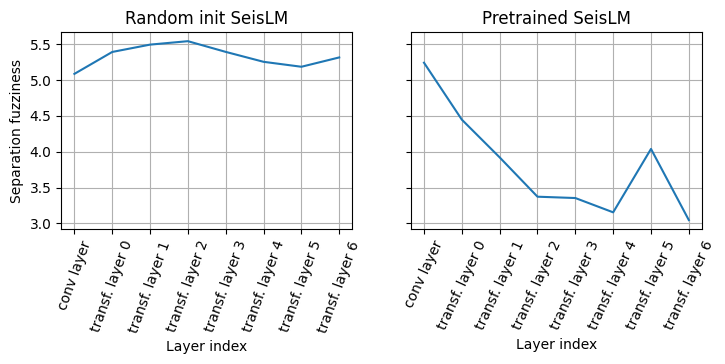

In [9]:
a4_width = 8.27
fig_width = a4_width
fig_height = fig_width / 2 / 1.618

fig, (ax_col1, ax_col2) = plt.subplots(
  1, 2, figsize=(fig_width, fig_height), sharey=True)

ax_col1.plot(fuzziness_dict['random_init'], label='random_init')
ax_col1.set_title('Random init SeisLM')
ax_col1.grid()
ax_col1.set_ylabel('Separation fuzziness')
ax_col1.set_xlabel('Layer index')
ax_col1.set_xticks(range(len(layer_labels)))
ax_col1.set_xticklabels(layer_labels, rotation=70)

ax_col2.plot(fuzziness_dict['pretrained'], label='pretrained')
ax_col2.set_title('Pretrained SeisLM')
ax_col2.set_xlabel('Layer index')
ax_col2.set_xticks(range(len(layer_labels)))
ax_col2.set_xticklabels(layer_labels, rotation=65)
ax_col2.grid()


In [10]:
seislm_kwargs = {
  'color': '#1b7837',
  'linestyle': '-',
  'lw': 2,
  'marker': 'o',
}

random_init_seislm_kwargs = {
  'color': 'gray',
  'linestyle': '--',
  'lw': 2,
  'marker': 's'
}


model_kwargs = {}
# model_kwargs['PhaseNet'] = phasenet_kwargs
# model_kwargs['EQTransformer'] = eqtransformer_kwargs
model_kwargs['pretrained'] = seislm_kwargs
model_kwargs['random_init'] = random_init_seislm_kwargs


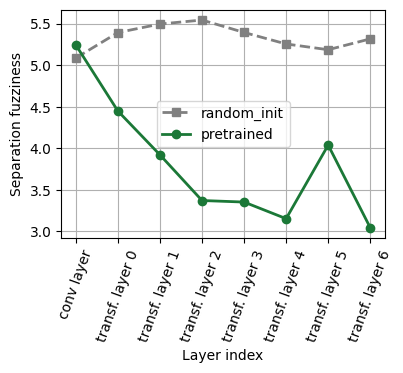

In [15]:
a4_width = 8.27
fig_width = a4_width / 2
fig_height = 1.5 * fig_width / 1.618

fig, ax = plt.subplots(
  1, 1, figsize=(fig_width, fig_height), sharey=True
)

ax.plot(fuzziness_dict['random_init'], label='random_init', **random_init_seislm_kwargs)
ax.plot(fuzziness_dict['pretrained'], label='pretrained', **seislm_kwargs)

ax.grid()
ax.set_ylabel('Separation fuzziness')
ax.set_xlabel('Layer index')
ax.set_xticks(range(len(layer_labels)))
ax.set_xticklabels(layer_labels, rotation=70)
ax.legend()
plt.tight_layout()
# plt.subplots_adjust(left=0.1, bottom=0.5)
# fig.savefig(project_path.FIGURE_DIR + f'/separation_fuzziness.pdf')
fig.savefig(project_path.FIGURE_DIR + f'/separation_fuzziness.png')



In [ ]:
fuzziness_dict['random_init']

[5.751149755639218,
 5.777602248940402,
 5.901510560356989,
 5.896415292502151,
 5.770775132415529,
 5.885725099920277,
 5.786885439982731,
 6.026855139141832]